# 累積報酬，以0050為例，KD值低檔(30)黃金交叉作為買進訊號

In [1]:
import pandas_datareader as pdr
import pandas as pd
import talib
%matplotlib inline

start = '2018-01-01'
df = pdr.DataReader('0050.TW', 'yahoo', start)
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-01-02,82.599998,82.150002,82.150002,82.599998,3613199.0,76.800766
2018-01-03,83.449997,82.949997,82.949997,83.349998,7196437.0,77.498116
2018-01-04,83.650002,83.199997,83.500000,83.500000,5627565.0,77.637581
2018-01-05,83.800003,83.300003,83.500000,83.750000,7616796.0,77.870033
2018-01-08,84.150002,83.699997,83.800003,84.099998,5189611.0,78.195450


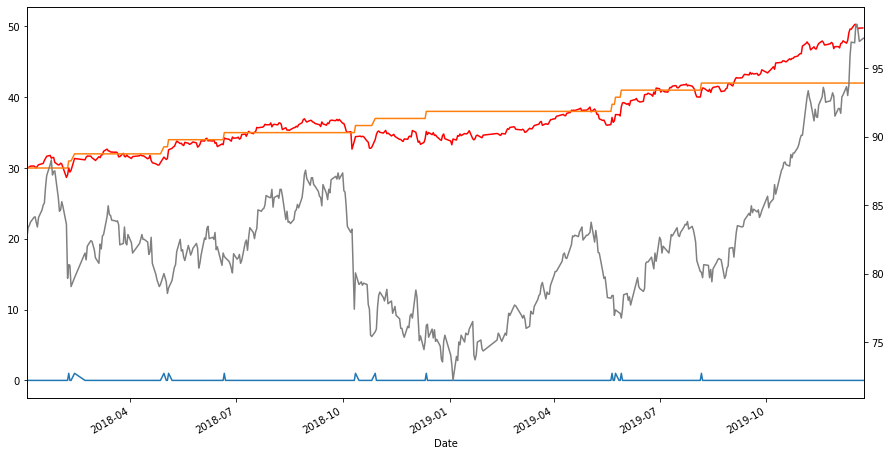

In [2]:
kd = talib.STOCH(df['High'].ffill().values, 
                 df['Low'].ffill().values, 
                 df['Close'].ffill().values,
                 fastk_period=9, slowk_period=3, slowd_period=3, slowk_matype=1, slowd_matype=1)

k = pd.Series(kd[0], index=df['Close'].index)
d = pd.Series(kd[1], index=df['Close'].index)

buy = (k > d) & (k.shift(1) < d.shift(1)) & (k < 30)

# 起始資金為 30 萬
arr = [30]
for v, p in zip(buy[1:], df['Close'].shift(-2)/df['Close'].shift(-1)):
    arr.append(arr[-1]*p + v)

# 每次有訊號出來時就投入1萬
# 先畫出 2330 收盤價
df['Close'].plot(secondary_y=True, color='gray')

# 畫出投資獲利
pd.Series(arr, index=df['Close'].index).plot(color='red')

# 畫出買入的時間點
buy.astype(int).plot()

# 每次有訊號出來時就投入1萬，如放在銀行，的資產變化
(buy.astype(int).cumsum() + 30).plot(figsize=(15,8))

# 夏普比率 (Sharpe Ratio)

- 夏普比率是計算風險調整回報的一種指標，並且已經成為這種計算的行業標準
- 計算投資組合每承受一單位總風險，會產生多少的超額報酬。

$\text{夏普比率}(Sharpe ratio)$ = $\frac{平均投資組合收益率 - 無風險利率}{投資組合收益率的標準差}$ 或 
$\frac{平均年化報酬率-無風險利率}{年化標準差}$ 或 
$\frac{每日報酬率平均值- 無風險利率}{每日報酬的標準差}\times 252^{0.5}$

$ 每日報酬 = \frac{今天資產淨值-昨天資產淨值}{昨天資產淨值}$


原夏普比率

年化夏普比率= K值 * 原夏普比率

各種採樣率的K值：

* Daily = $\sqrt{252}$
* Weekly = $\sqrt{52}$
* Monthly = $\sqrt{12}$

無風險利率是指您將資金存入銀行或政府債券時可獲得的利率，我們假設為0％。 如果您所在的國家/地區的交易貨幣匯率較高，您可以使用此技巧將每年匯率轉換為每日匯率：

$\text{daily rate}$ = $((1+\text{yearly rate})^\frac{1}{252})-1$

更多：夏普比率 https://www.investopedia.com/terms/s/sharperatio.asp

In [58]:
%pylab inline
import pandas_datareader as pdr
import pandas as pd
import backtest
start = '2017-01-01'
df = pdr.DataReader('2330.TW', 'yahoo', start)
df.head()

Populating the interactive namespace from numpy and matplotlib


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-01-03,183.5,181.0,181.5,183.0,22630000.0,162.938599
2017-01-04,184.0,181.5,183.0,183.0,24369000.0,162.938599
2017-01-05,183.5,181.5,182.0,183.5,20979000.0,163.383789
2017-01-06,184.5,183.5,184.0,184.0,22443000.0,163.828949
2017-01-09,185.0,183.0,184.0,184.0,18569000.0,163.828949


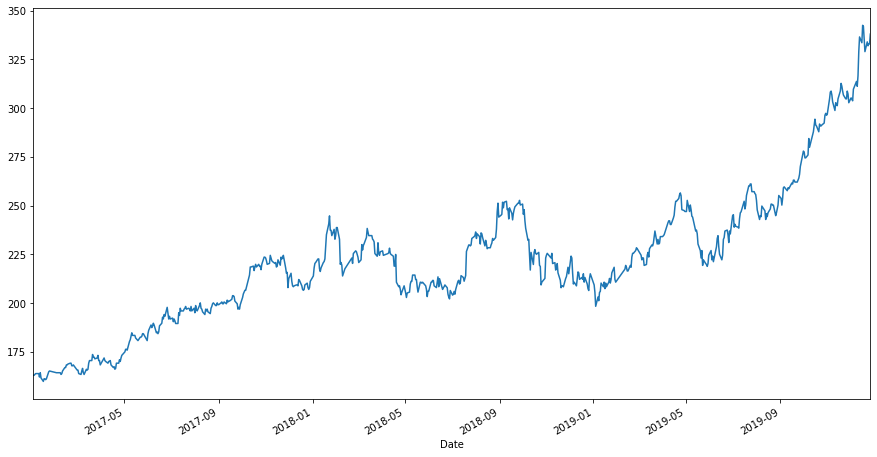

In [59]:
df['Adj Close'].plot(figsize=(15, 8))

## 每日報酬率(每日回報)

In [47]:
#每日投資報酬率，方法1
dailyRet = df['Adj Close'].pct_change()
dailyRet.head()

Date
2017-01-03         NaN
2017-01-04    0.000000
2017-01-05    0.002732
2017-01-06    0.002725
2017-01-09    0.000000
Name: Adj Close, dtype: float64

In [10]:
#每日投資報酬率，方法2
dailyRet = (df['Adj Close'] -  df['Adj Close'].shift(1)) / df['Adj Close'].shift(1) 
dailyRet.head()

Date
2017-01-03         NaN
2017-01-04    0.000000
2017-01-05    0.002732
2017-01-06    0.002725
2017-01-09    0.000000
Name: Adj Close, dtype: float64

In [11]:
#每日投資報酬率，方法2
dailyRet = df['Adj Close'] / df['Adj Close'].shift(1) -1
dailyRet.head()

Date
2017-01-03         NaN
2017-01-04    0.000000
2017-01-05    0.002732
2017-01-06    0.002725
2017-01-09    0.000000
Name: Adj Close, dtype: float64

In [69]:
#假設無風險利率為 4%
#假設一年有252個交易日
excessRet = dailyRet - 0.04/252

sharpeRatio = np.sqrt(252.0)*np.mean(excessRet)/np.std(excessRet)
sharpeRatio

1.0842653302673588

## 每日報酬率(每日回報)
### 1. 假設無風險利率為 0%

In [60]:
df['Daily Return'] = df['Adj Close'].pct_change(1)
df.head()

,High,Low,Open,Close,Volume,Adj Close,Daily Return
Date,,,,,,,
2017-01-03,183.5,181.0,181.5,183.0,22630000.0,162.938599,NaN
2017-01-04,184.0,181.5,183.0,183.0,24369000.0,162.938599,0.000000
2017-01-05,183.5,181.5,182.0,183.5,20979000.0,163.383789,0.002732
2017-01-06,184.5,183.5,184.0,184.0,22443000.0,163.828949,0.002725
2017-01-09,185.0,183.0,184.0,184.0,18569000.0,163.828949,0.000000


## 每日報酬率(每日回報)
### 2. 假設無風險利率為 4%

In [61]:
df['Daily Return_4%'] = df['Adj Close'].pct_change(1) - 0.04/252
df.head()

,High,Low,Open,Close,Volume,Adj Close,Daily Return,Daily Return_4%
Date,,,,,,,,
2017-01-03,183.5,181.0,181.5,183.0,22630000.0,162.938599,NaN,NaN
2017-01-04,184.0,181.5,183.0,183.0,24369000.0,162.938599,0.000000,-0.000159
2017-01-05,183.5,181.5,182.0,183.5,20979000.0,163.383789,0.002732,0.002574
2017-01-06,184.5,183.5,184.0,184.0,22443000.0,163.828949,0.002725,0.002566
2017-01-09,185.0,183.0,184.0,184.0,18569000.0,163.828949,0.000000,-0.000159


## 累積報酬率(累積回報)
#### 累積報酬率 = (期末金額/期初金額 - 1) * 100

In [62]:
cum_re = 100 * (df['Adj Close'][-1]/df['Adj Close'][0] - 1)
print('累積回報 {}%!'.format(cum_re))

累積回報 107.44010494511133%!


## 每日平均報酬
#### 無風險利率為 0%

In [63]:
df['Daily Return'].mean()

0.0011007789288099935

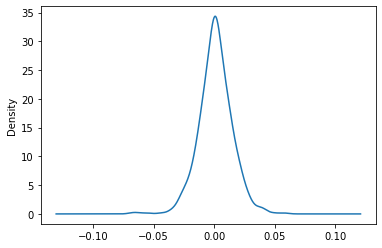

In [64]:
df['Daily Return'].plot(kind='kde')

## 每日平均報酬
#### 無風險利率為 4%

In [65]:
df['Daily Return_4%'].mean()

0.0009420487700798455

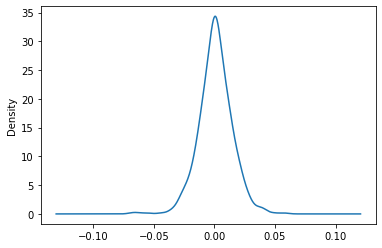

In [66]:
df['Daily Return_4%'].plot(kind='kde')

## 夏普比率
#### 無風險利率為 0%

In [70]:
SR = df['Daily Return'].mean()/df['Daily Return'].std()
SR

0.07975588061551894

In [71]:
ASR = (252**0.5)*SR
ASR

1.2660853542217214

## 夏普比率
#### 無風險利率為 4%

In [67]:
SR4 = df['Daily Return_4%'].mean()/df['Daily Return_4%'].std()
SR4

0.06825523933466711

In [68]:
ASR4 = (252**0.5)*SR4
ASR4

1.0835183337403376

# 計算最大虧損額(MaxDD)跟最大虧損率(MaxDDD)
![](MDD.jpg)
[圖片來源](https://jointrader.com/quantitative_trading/readreport/)

[參考說明](https://www.investopedia.com/terms/d/drawdown.asp)

# 最大虧損額及最大虧損持續時間

In [6]:
#累積收益率
cumRet = np.cumprod(1 + dailyRet)

In [7]:
backtest.calc_max_drawdown(cumRet)

-0.21509434278953132

In [8]:
dd_series = backtest.to_drawdown_series(cumRet)
dd_series.head()

Date
2017-01-03    NaN
2017-01-04    0.0
2017-01-05    0.0
2017-01-06    0.0
2017-01-09    0.0
Name: Adj Close, dtype: float64

In [9]:
dd_details = backtest.drawdown_details(dd_series)
dd_details.head()

,Start,End,Length,drawdown
0,2017-01-03 00:00:00,2017-01-04 00:00:00,1,0
1,2017-01-11 00:00:00,2017-01-12 00:00:00,1,-0.0108694
2,2017-01-13 00:00:00,2017-01-23 00:00:00,10,-0.0271002
3,2017-02-02 00:00:00,2017-02-13 00:00:00,11,-0.0107816
4,2017-02-22 00:00:00,2017-03-17 00:00:00,23,-0.0342104


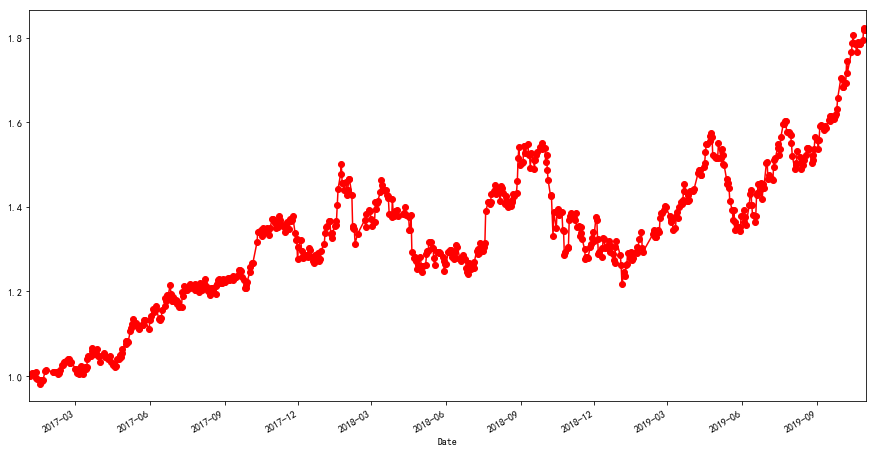

In [10]:
cumRet.plot(style='ro-', figsize= (15, 8))

In [20]:
backtest.DrawDownAnalysis(cumRet)

(-0.21509434278953132, 217)

# 策略1：20日最大與10日最小通道

In [79]:
%pylab inline
import pandas_datareader as pdr
import pandas as pd
import talib

start = '2018-01-01'
df = pdr.DataReader('2330.TW', 'yahoo', start)
df.head()

Populating the interactive namespace from numpy and matplotlib


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-01-02,232.5,231.0,231.5,232.5,18055269.0,213.912537
2018-01-03,238.0,235.5,236.0,237.0,29308091.0,218.052811
2018-01-04,240.0,236.5,240.0,239.5,29096613.0,220.352921
2018-01-05,240.0,238.0,240.0,240.0,22438255.0,220.812943
2018-01-08,242.5,240.5,242.0,242.0,20233692.0,222.653061


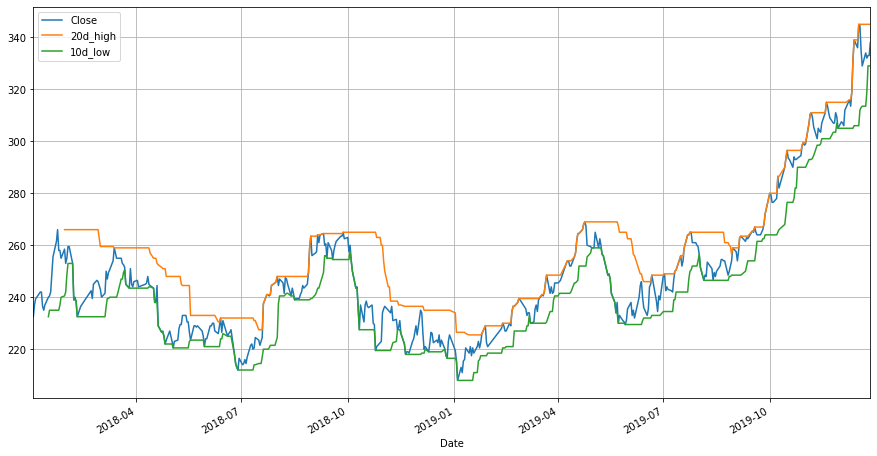

In [80]:
df['20d_high'] = pd.Series.rolling(df['Close'], window=20).max()
df['10d_low'] = pd.Series.rolling(df['Close'], window=10).min()
df[['Close','20d_high','10d_low']].plot(grid=True, figsize=(15,8))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
C:\Progr

    price operation  ops_diff  profit
1   232.0       Buy       NaN     NaN
2   225.0      Sell      -7.0    -7.0
3   237.5       Buy      12.5     NaN
4   240.5      Sell       3.0     3.0
5   249.5       Buy       9.0     NaN
6   255.0      Sell       5.5     5.5
7   265.0       Buy      10.0     NaN
8   254.0      Sell     -11.0   -11.0
9   226.0       Buy     -28.0     NaN
10  230.0      Sell       4.0     4.0
11  241.0       Buy      11.0     NaN
12  256.5      Sell      15.5    15.5
13  248.5       Buy      -8.0     NaN
14  251.5      Sell       3.0     3.0
15  259.0       Buy       7.5     NaN
16  305.0      Sell      46.0    46.0
17  316.0       Buy      11.0     NaN
勝率 75.00%
平均獲利金額 12.83
平均虧損金額 9.00
盈虧比 1.43
風報比 5.36
總損益 59.00
交易次數 8
獲利金額 77.00
獲利次數 6
虧損金額 18.00
虧損次數 2
單次最大虧損 -11.0
單次最大獲利 46.0


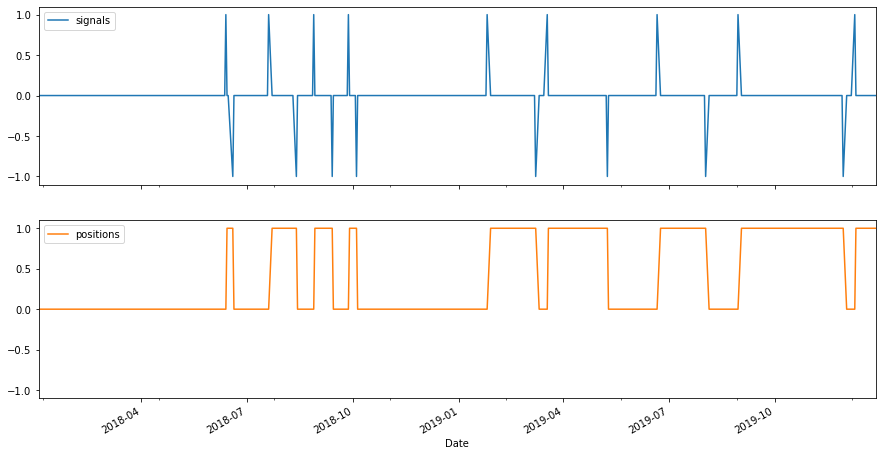

In [89]:
import numpy as np

def breakout(df):
    # Donchian Channel
    df['20d_high'] = pd.Series.rolling(df['Close'], window=20).max()
    df['10d_low'] = pd.Series.rolling(df['Close'], window=10).min()

    has_position = False
    df['signals'] = np.zeros(np.size(df['Close']))    
    
    for t in range(2, df['signals'].size):
        if df['Close'][t] > df['20d_high'][t-1]:
            if not has_position:
                df.loc[df.index[t], 'signals'] = 1
                has_position = True
        elif df['Close'][t] < df['10d_low'][t-1]:
            if has_position:
                df.loc[df.index[t], 'signals'] = -1
                has_position = False
                
    df['positions'] = df['signals'].cumsum().shift()

    df[['signals', 'positions']].plot(subplots = True, ylim=(-1.1, 1.1), figsize = (15, 8))
    profit(df)

def profit(data):
 
    trade = pd.concat([
 
        pd.DataFrame({"price": data.loc[data["signals"] == 1, "Close"],
 
                      "operation": "Buy"}),
 
        pd.DataFrame({"price": data.loc[data["signals"] == -1, "Close"],
 
                      "operation": "Sell"}),
 
    ])
 
    trade.sort_index(inplace=True)
    trade.index = range(1, len(trade) + 1)
 
    trade['ops_diff'] = trade['price'].diff()
 
    trade['profit'] = trade[trade['operation'] == 'Sell']['ops_diff']  
    
    wintimes = np.sum(1 for x in trade['profit'] if x > 0)
    tradetimes = int(len(trade['profit'].dropna()))

    losttimes = np.sum(1 for x in trade['profit'] if x < 0)

    sum_win_price = np.sum((n) for n in trade['profit'] if n > 0)
    sum_win_price_times = (np.sum(1 for x in trade['profit'] if x > 0))

    sum_lose_price = np.sum((abs(n)) for n in trade['profit'] if n < 0)
    sum_lose_price_times = np.sum(1 for x in trade['profit'] if x < 0)

    Total_profit_and_loss = trade['profit'].sum()
    
    print(trade)
    
    print("勝率","%.2f%%" % (wintimes / tradetimes * 100))
 
    print("平均獲利金額", "%.2f" % (sum_win_price / sum_win_price_times))
 
    print("平均虧損金額", "%.2f" % (sum_lose_price / sum_lose_price_times))
 
    print("盈虧比", "%.2f" % ((sum_win_price / sum_win_price_times) / (sum_lose_price / sum_lose_price_times)))
    
    print("風報比", "%.2f" % (Total_profit_and_loss / abs(min((trade['profit'].dropna())))))
 
    print("總損益", "%.2f" % (Total_profit_and_loss))
 
    print("交易次數", tradetimes)
 
    print("獲利金額", "%.2f" % (sum_win_price))
 
    print("獲利次數", wintimes)
 
    print("虧損金額", "%.2f" % (sum_lose_price))
 
    print("虧損次數", losttimes)
 
    print("單次最大虧損", min((trade['profit'].dropna())))
 
    print("單次最大獲利", max((trade['profit'].dropna())))

pd.set_option("display.max_rows", None)
breakout(df)

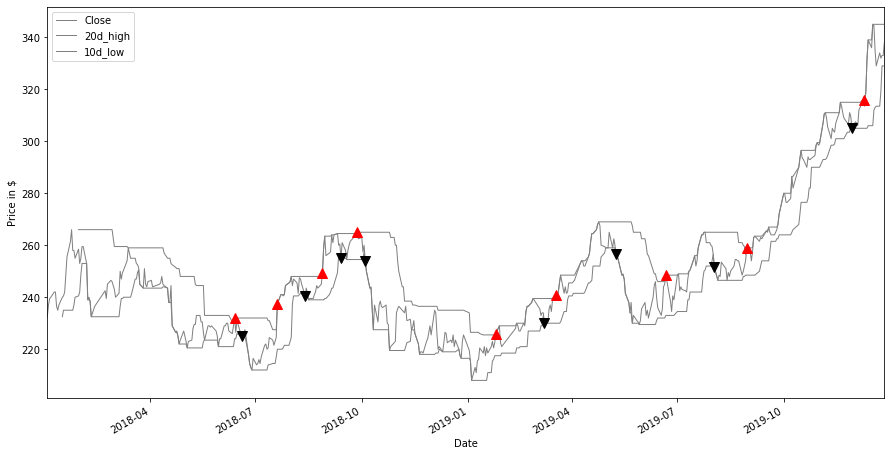

In [90]:
fig = plt.figure()
ax1 = fig.add_subplot(111,  ylabel='Price in $')
    
df[['Close','20d_high','10d_low']].plot(ax=ax1, color='gray', lw=1., figsize=(15,8))

# Plot the "buy" trades
ax1.plot(df.loc[df.signals == 1].index,df['Close'][df.signals == 1],'^', markersize=10, color='r')

# Plot the "sell" trades
ax1.plot(df.loc[df.signals == -1].index, df['Close'][df.signals == -1], 'v', markersize=10, color='k')

In [91]:
#計算每日收益率，計算每天漲了x％
dailyRet = df['Close'].pct_change()

#假設無風險利率為 4%
#假設一年有252個交易日
import numpy as np
yearofdays = 252
#計算超額回報率
excessRet = (dailyRet - 0.04/yearofdays)[df['positions']==1.0]
#計算年化夏普比率，預設為252個交易日。
sharpeRatio = np.sqrt(yearofdays*1.0)*np.mean(excessRet)/np.std(excessRet) #年化報酬
sharpeRatio

1.5881912074974656

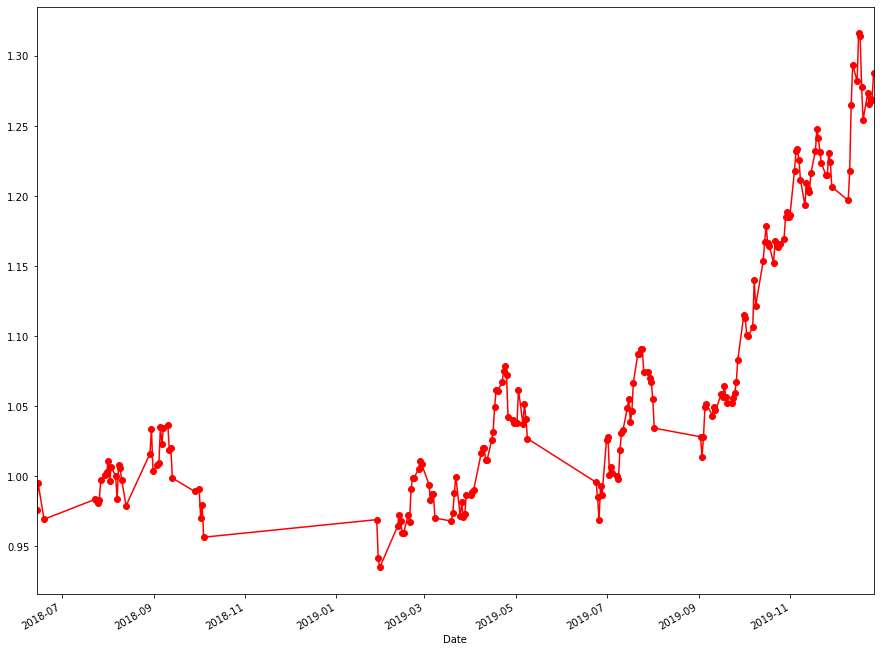

In [92]:
cumRet = np.cumprod(1 + excessRet)
cumRet.plot(style='ro-', figsize = (15 , 12))

## 財務函數庫
-[ffn](http://pmorissette.github.io/ffn/index.html)

In [169]:
!pip install ffn

In [8]:
import ffn
import numpy as np
def DrawDownAnalysis(cumRet):
    dd_series = ffn.core.to_drawdown_series(cumRet)
    dd_details = ffn.core.drawdown_details(dd_series)
    return dd_details['drawdown'].min(), dd_details['Length'].max()

In [9]:
DrawDownAnalysis(cumRet)

(-0.10205879175305521, 218)

# 策略2：股價在20MA上買進，20MA以下賣出

In [174]:
import pandas_datareader as pdr
import numpy as np
import pandas as pd
import talib
start = '2018-01-01'
df = pdr.DataReader('2330.TW', 'yahoo', start)
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-01-02,232.5,231.0,231.5,232.5,18055269.0,215.476227
2018-01-03,238.0,235.5,236.0,237.0,29308091.0,219.646744
2018-01-04,240.0,236.5,240.0,239.5,29096613.0,221.963684
2018-01-05,240.0,238.0,240.0,240.0,22438255.0,222.427078
2018-01-08,242.5,240.5,242.0,242.0,20233692.0,224.280640


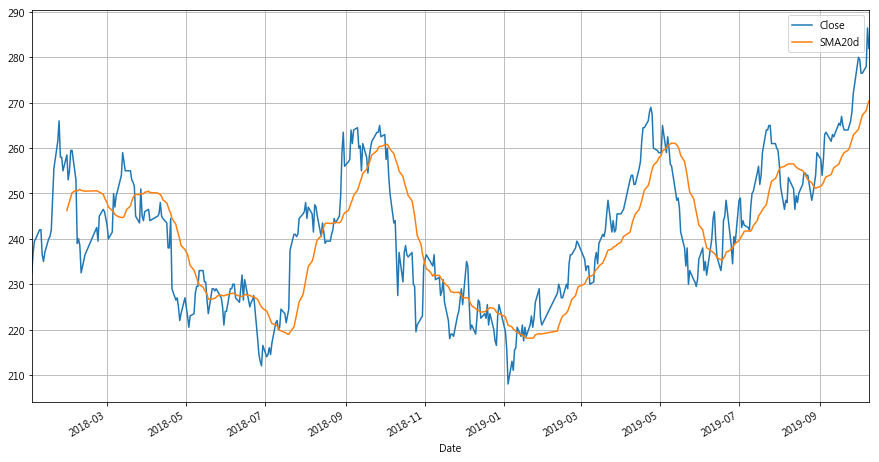

In [175]:
import matplotlib.pyplot as plt

df['SMA20d'] = df['Close'].rolling(window= 20).mean()
df[['Close','SMA20d']].plot(grid=True, figsize=(15,8))
plt.show()

Populating the interactive namespace from numpy and matplotlib


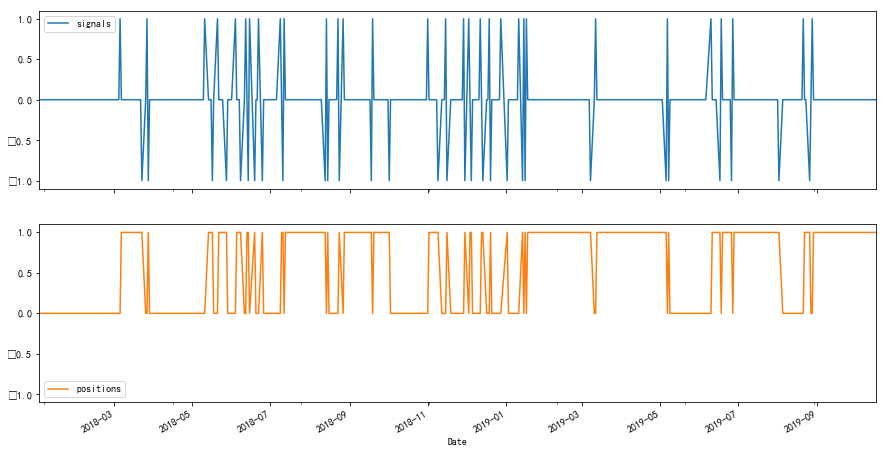

In [10]:
%pylab inline
def breakout2(df):
    # Donchian Channel
    df['SMA20'] = talib.SMA(df['Close'], timeperiod=20)

    has_position = False
    df['signals'] = np.zeros(np.size(df['Close']))
    for t in range(2, df['signals'].size):
        if (df['Close'][t] > df['SMA20'][t]) & (df['Close'][t-1] < df['SMA20'][t-1]):
            if not has_position:
                df.loc[df.index[t], 'signals'] = 1
                has_position = True
        elif (df['Close'][t] < df['SMA20'][t]) & (df['Close'][t-1] > df['SMA20'][t-1]):
            if has_position:
                df.loc[df.index[t], 'signals'] = -1
                has_position = False

    df['positions'] = df['signals'].cumsum().shift()

    df[['signals', 'positions']].plot(subplots = True, ylim=(-1.1, 1.1), figsize = (15, 8))
breakout2(df)

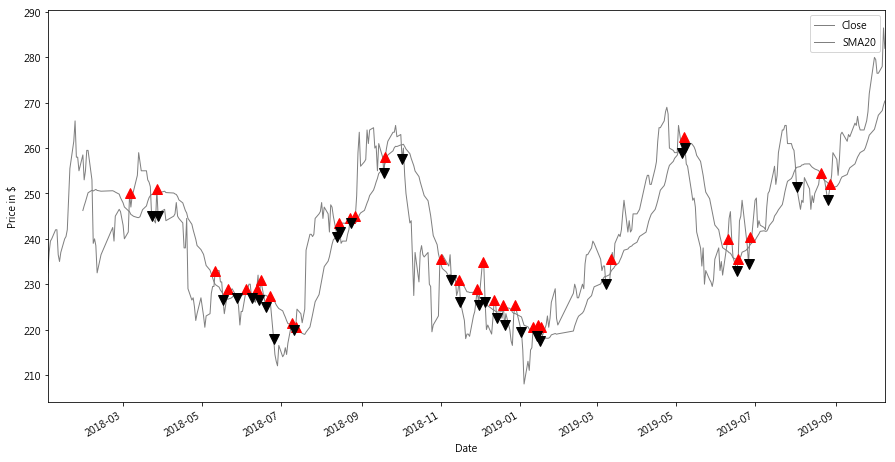

In [177]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax1 = fig.add_subplot(111,  ylabel='Price in $')
    
df[['Close','SMA20']].plot(ax=ax1, color='gray', lw=1., figsize=(15,8))

# Plot the "buy" trades
ax1.plot(df.loc[df.signals == 1].index,df['Close'][df.signals == 1],'^', markersize=10, color='r')

# Plot the "sell" trades
ax1.plot(df.loc[df.signals == -1].index, df['Close'][df.signals == -1], 'v', markersize=10, color='k')

In [178]:
dailyRet = df['Close'].pct_change()

In [179]:
#假設無風險利率為 4%
#假設一年有252個交易日

import numpy as np

yearofdays = 252
excessRet = (dailyRet - 0.04/yearofdays)[df['positions']==1.0]
sharpeRatio = np.sqrt(yearofdays*1.0)*np.mean(excessRet)/np.std(excessRet)
sharpeRatio

-0.1823757648092543

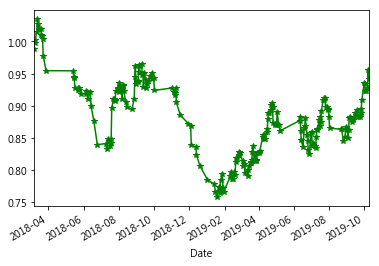

In [180]:
cumRet = np.cumprod(1 + excessRet)
cumRet.plot(style='g*-')

In [181]:
import ffn
import numpy as np
def DrawDownAnalysis(cumRet):
    dd_series = ffn.core.to_drawdown_series(cumRet)
    dd_details = ffn.core.drawdown_details(dd_series)
    return dd_details['drawdown'].min(), dd_details['Length'].max()

In [182]:
DrawDownAnalysis(cumRet)

(-0.26753369352947742, 574)

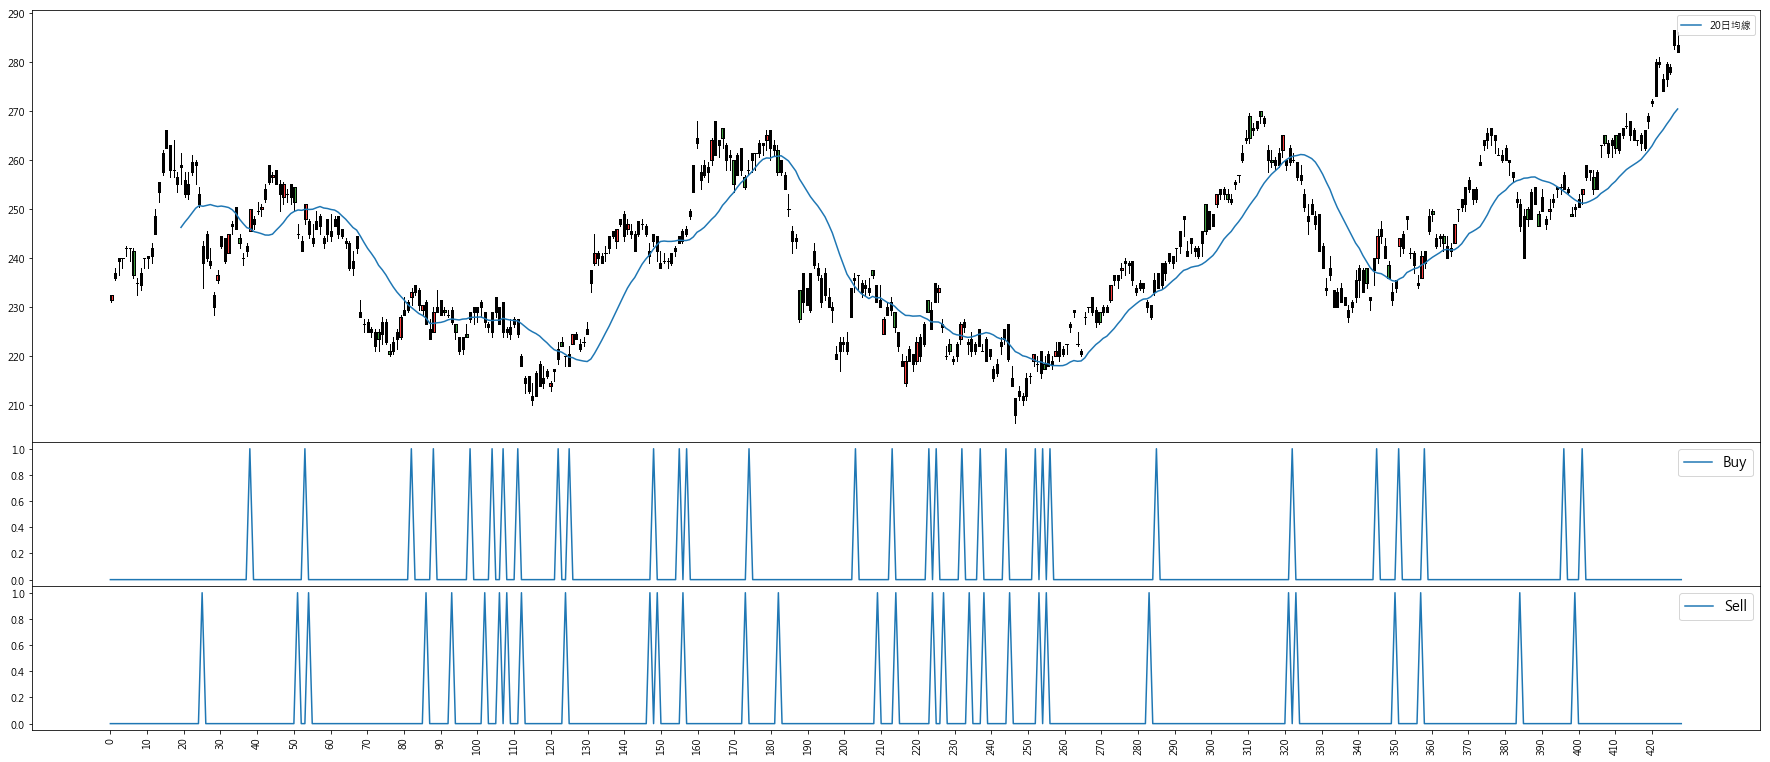

In [183]:
import matplotlib.pyplot as plt
import matplotlib.finance as mpf
import talib
import numpy as np
import pandas_datareader as pdr
import pandas as pd

start = '2018-01-01'
df = pdr.DataReader('2330.TW', 'yahoo', start)
df.reset_index(inplace=True)
fig = plt.figure(figsize=(24, 20))

df['SMA20'] = talib.SMA(np.array(df['Close']), 20)
df['Buy'] =  (df['Close'] > df['SMA20']) & (df['Close'].shift() < df['SMA20'].shift())
df['Sell'] =  (df['Close'] < df['SMA20']) & (df['Close'].shift() > df['SMA20'].shift())

ax  = fig.add_axes([0, 0.3, 1, 0.3]) ##左下角座標 (0,0.3)，寬高 (1,0.4)
ax2 = fig.add_axes([0, 0.2, 1, 0.1]) ##左下角座標 (0,0.2)，寬高 (1,0.1)
ax3 = fig.add_axes([0, 0.1, 1, 0.1]) ##左下角座標 (0,0.1)，寬高 (1,0.1)

ax.set_xticks(range(0, len(df.index), 10))
ax.set_xticklabels(df.index[::10])
mpf.candlestick2_ochl(ax, df['Open'], df['Close'], df['High'],
                      df['Low'], width=0.6, colorup='r', colordown='g', alpha=0.75)

plt.rcParams['font.sans-serif']=['Microsoft JhengHei'] 
ax.plot(df['SMA20'], label='20日均線')

ax2.plot(df['Buy'], label='Buy')
ax3.plot(df['Sell'], label='Sell')

ax3.set_xticks(range(0, len(df.index), 10))
ax3.set_xticklabels(df.index[::10],rotation=90)

ax.legend()
ax2.legend(fontsize=14)
ax3.legend(fontsize=14)
plt.show()